# 1. Requirements

In order to train the models, the following Python and TensorFlow versions are required:  

Python: 3.10  
TensorFlow: 2.17.0

It is recommended to train this model on a high-performance GPU or TPU. For the current training, Google Colab's A100 GPU was used.

## 1.1. Check if requirements are satisfied

In [ ]:
print ('Current Python version :')
!python --version

import sys
print(sys.executable)

import tensorflow as tf
print('Current Tesorflow version :'+ tf.__version__)

Current Python version :
Python 3.10.12
/usr/bin/python3
Current Tesorflow version :2.17.0


# 2. Connect to Google Drive

In [1]:
import os
from google.colab import drive
drive.mount('/content/gdrive')

# Change working directory to be current folder
# os.chdir('/content/gdrive/My Drive/Your Folder Name/Your sub Folder Name')
os.chdir('/content/gdrive/My Drive/Colab Notebooks/LDS-Net')
!ls

Mounted at /content/gdrive
'Backup of LDS-Net-Model-Creation_Enhanced_26_10.ipynb'   LDS-Net-Model-Creation.ipynb
 Data							  lds_net_model_initial.png
 lds_net_best_model.keras				  lds_net_model.keras
 LDS-Net-Model-Creation_100perc.ipynb			  lds_net_models
 LDS-Net-Model-Creation_40perc.ipynb			  lds_net_weights.weights.h5
 LDS-Net-Model-Creation_Enhanced_26_10.ipynb		  model_plots
 LDS-Net-Model-Creation_Enhanced.ipynb			  Models-Old
 LDS-Net-Model-Creation_Improved.ipynb			  TestImages.ipynb


# 3. Import Required Libraries

In [2]:
#!pip install pandas numpy tensorflow matplotlib

import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, GlobalAveragePooling2D, Dense, Multiply, Add, Activation, Concatenate, BatchNormalization, Layer, DepthwiseConv2D, Lambda, Reshape
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import plot_model, Sequence
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.saving import register_keras_serializable, save_model, load_model
from keras.config import enable_unsafe_deserialization
enable_unsafe_deserialization()
from tensorflow.keras.optimizers import Adam
import random
import time
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

# 4. LDS-Net Model Creation

## 4.1. Defining the Utility functions

### Model Blocks Description

#### Utility Functions
These utility functions handle the output shapes for pooling layers. The `output_shape_avg` function returns the shape after applying average pooling, while `output_shape_max` does the same for max pooling. Both functions adjust the last dimension to represent the pooling operation's output.

#### Contrast Adjust Layer
The `ContrastAdjustLayer` is a custom layer that adjusts the contrast of the input images. It calculates the mean pixel value across the spatial dimensions and then scales the pixel values to enhance or reduce contrast based on a specified `contrast_factor`. This layer helps improve the visibility of details in the images.

#### Brightness Adjust Layer
The `BrightnessAdjustLayer` modifies the brightness of the input images by adding a specified `brightness_factor` to each pixel value. This layer is crucial for correcting lighting issues that may arise in underwater photography, where colors can appear washed out or overly dark.

#### Global Histogram Equalization Layer
The `GlobalHistEqLayer` applies global histogram equalization to enhance the overall contrast of the input images. It first converts the input to the YUV color space, where it equalizes the luminance channel (Y) to improve the distribution of pixel intensities, resulting in better visual contrast and detail recovery.

#### Average Pooling Layer
The `AvgPoolLayer` computes the average value of the input tensor along the specified axis. This operation reduces the spatial dimensions of the feature maps while retaining important information, allowing for more abstract representations of the input.

#### Max Pooling Layer
Similar to the average pooling layer, the `MaxPoolLayer` computes the maximum value across the specified axis. This operation helps in retaining the most significant features while reducing the size of the feature maps, which aids in computational efficiency and focuses on the strongest signals in the input.

#### Sobel Conv Layer
The `SobelConvLayer` applies Sobel filters to the input images to detect edges and gradients. By convolving the input with predefined kernels, it enhances fine details and edges, which are essential for detecting structures and patterns within underwater images.

#### Decomposition Block
The `decomposition_block` separates the processing of local and global features. It applies edge detection through Sobel filters in the local stream while enhancing the overall structure with global histogram equalization, brightness, and contrast adjustments in the global stream.

#### Attention Block
The `attention_block` fuses local and global features by creating query and key representations. It computes attention scores to identify important regions in the image, enabling the model to focus on significant features and enhance the final output accordingly.

#### Fusion Module
The `fusion_module` combines the outputs of the local and global streams into a single representation. This process integrates different aspects of the image, allowing the model to leverage both fine details and broader contextual information for improved image enhancement.

#### Convolution, Batch Normalization, and ReLU Activation
The `conv_bn_relu` function implements a standard sequence of operations, including convolution, batch normalization, and ReLU activation. This combination stabilizes training, improves feature extraction, and helps prevent overfitting by normalizing the activations.

#### Residual Block
The `residual_block` introduces skip connections to the model, allowing gradients to flow more easily during backpropagation. This architecture mitigates the vanishing gradient problem and facilitates the training of deeper networks by maintaining useful features across layers.

#### Spatial Attention Block
The `spatial_attention` block computes average and max pooled feature maps to create an attention map that emphasizes important spatial features. By multiplying the input feature map with this attention map, the model focuses on the most relevant parts of the image.

#### Dense Block
The `dense_block` concatenates outputs from multiple convolutional layers, enhancing feature diversity. This structure allows the model to learn richer representations by combining low-level and high-level features, leading to better performance in image enhancement tasks.

#### Non-Local Block
The `non_local_block` captures long-range dependencies by computing relationships between pixels. It uses query, key, and value representations to enhance the feature maps, allowing the model to consider global context and improve the coherence of the output.

#### Multi-Scale Convolution
The `multi_scale_conv` function extracts features at different scales (3x3, 5x5, 7x7) through separate convolutional layers. This approach helps the model capture diverse information and patterns in the image, contributing to a more comprehensive understanding of the content.

#### Pyramid Pooling
The `pyramid_pooling` function applies pooling operations of varying sizes to gather multi-scale contextual information. By combining features from different resolutions, it enhances the model's ability to capture spatial hierarchies and contextual details.

#### Global Self-Attention
The `global_self_attention` mechanism captures global dependencies in the feature maps by computing attention scores based on query, key, and value representations. This technique ensures that the model pays attention to significant features across the entire image, leading to improved contextual understanding.

#### Channel Attention
The `channel_attention` mechanism focuses on important features by weighing the outputs of different channels. By applying a squeeze-and-excitation approach, it enhances the representational power of the model by allowing it to emphasize relevant channel responses based on their importance.


In [3]:
# Utility functions to handle output shapes for pooling layers
@register_keras_serializable()
def output_shape_avg(input_shape):
    return input_shape[:-1] + (1,)

@register_keras_serializable()
def output_shape_max(input_shape):
    return input_shape[:-1] + (1,)

# Custom layer to adjust contrast of the input
@register_keras_serializable()
class ContrastAdjustLayer(Layer):
    def __init__(self, contrast_factor=1.2, **kwargs):
        super(ContrastAdjustLayer, self).__init__(**kwargs)
        self.contrast_factor = contrast_factor

    def call(self, inputs):
        # Adjust contrast in a differentiable way (using multiplication)
        mean = tf.reduce_mean(inputs, axis=[1, 2], keepdims=True)  # Compute the mean pixel value
        adjusted = (inputs - mean) * self.contrast_factor + mean  # Adjust contrast
        return adjusted

# Custom layer to adjust brightness of the input
@register_keras_serializable()
class BrightnessAdjustLayer(Layer):
    def __init__(self, brightness_factor=0.1, **kwargs):
        super(BrightnessAdjustLayer, self).__init__(**kwargs)
        self.brightness_factor = brightness_factor

    def call(self, inputs):
        # Adjust brightness by adding a factor to the inputs
        adjusted = inputs + self.brightness_factor
        return adjusted


# Custom lay layer for global_histogram equalization
@register_keras_serializable()
class GlobalHistEqLayer(Layer):
    def __init__(self, **kwargs):
        super(GlobalHistEqLayer, self).__init__(**kwargs)
        self.conv = Conv2D(3, (1, 1), padding='same')

    def build(self, input_shape):
        self.conv.build(input_shape)
        self._trainable_weights = self.conv.trainable_weights
        super(GlobalHistEqLayer, self).build(input_shape)

    def call(self, inputs):

        # Convert 32-channel input to 3-channel
        x = self.conv(inputs)

        # Apply histogram equalization to the luminance channel in YUV color space
        yuv = tf.image.rgb_to_yuv(x)
        y_channel = tf.image.per_image_standardization(yuv[..., 0:1])  # Equalize the Y channel
        yuv = tf.concat([y_channel, yuv[..., 1:]], axis=-1)
        output = tf.image.yuv_to_rgb(yuv)

        return output

    def compute_output_shape(self, input_shape):
        return input_shape[:-1] + (3,)

# Average Pooling custom layer
@register_keras_serializable()
class AvgPoolLayer(Layer):
    def call(self, inputs):
        return K.mean(inputs, axis=-1, keepdims=True)

# Average Pooling custom layer
@register_keras_serializable()
class MaxPoolLayer(Layer):
    def call(self, inputs):
        return K.max(inputs, axis=-1, keepdims=True)


#The SobelConvLayer is designed to apply a Sobel filter to the input, which is commonly used in edge detection to highlight gradients or edges in an image.
@register_keras_serializable()
class SobelConvLayer(Layer):
    def __init__(self, **kwargs):
        super(SobelConvLayer, self).__init__(**kwargs)
        self.sobel_kernel_x = tf.constant([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=tf.float32)
        self.sobel_kernel_y = tf.constant([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=tf.float32)
        self.epsilon = 1e-6  # Small constant to prevent NaNs

    def build(self, input_shape):
        input_channels = int(input_shape[-1])
        self.sobel_kernel_x = tf.tile(self.sobel_kernel_x[:, :, tf.newaxis, tf.newaxis], [1, 1, input_channels, 1])
        self.sobel_kernel_y = tf.tile(self.sobel_kernel_y[:, :, tf.newaxis, tf.newaxis], [1, 1, input_channels, 1])
        self.built = True

    def call(self, inputs):
        sobel_x = tf.nn.depthwise_conv2d(inputs, self.sobel_kernel_x, strides=[1, 1, 1, 1], padding='SAME')
        sobel_y = tf.nn.depthwise_conv2d(inputs, self.sobel_kernel_y, strides=[1, 1, 1, 1], padding='SAME')

        # Add epsilon to prevent sqrt of zero
        gradient_magnitude = tf.sqrt(tf.square(sobel_x) + tf.square(sobel_y) + self.epsilon)
        return gradient_magnitude


# Decomposition block - separates local and global features
def decomposition_block(input_tensor):
    # Local: Edge detection (fine detail enhancement) using Sobel-like filters
    local = Conv2D(32, (3, 3), padding='same', name='decomposition_local')(input_tensor)
    local = SobelConvLayer()(local)  # Apply Sobel edge detection

    # Global: Contrast enhancement (broad structure enhancement)
    global_ = Conv2D(32, (5, 5), padding='same', name='decomposition_global')(input_tensor)
    global_ = GlobalHistEqLayer()(global_)  # Apply global histogram equalization
    global_ = BrightnessAdjustLayer()(global_)  # Adjust brightness
    global_ = ContrastAdjustLayer()(global_)  # Adjust contrast

    return local, global_


# Attention block for fusing local and global features
def attention_block(x, g, inter_channel, name_prefix):
    theta_x = Conv2D(inter_channel, (1, 1), padding='same', name=f'{name_prefix}_theta_x')(x)
    phi_g = Conv2D(inter_channel, (1, 1), padding='same', name=f'{name_prefix}_phi_g')(g)
    f = Activation('relu', name=f'{name_prefix}_relu')(Add(name=f'{name_prefix}_add')([theta_x, phi_g]))
    psi_f = Conv2D(1, (1, 1), padding='same', name=f'{name_prefix}_psi_f')(f)
    rate = Activation('sigmoid', name=f'{name_prefix}_sigmoid')(psi_f)
    att_x = Multiply(name=f'{name_prefix}_multiply')([x, rate])
    return att_x

# Fusion module to combine local and global feature maps
def fusion_module(local, global_):
    concat = Concatenate(name='fusion_concat')([local, global_])
    fused = Conv2D(128, (3, 3), padding='same', name='fusion_fused')(concat)
    return fused

# Convolution followed by Batch Normalization and ReLU activation
def conv_bn_relu(x, filters, kernel_size, name_prefix, dilation_rate=1):
    x = Conv2D(filters, kernel_size, padding='same', dilation_rate=dilation_rate, name=f'{name_prefix}_conv')(x)
    x = BatchNormalization(name=f'{name_prefix}_bn')(x)
    x = Activation('relu', name=f'{name_prefix}_relu')(x)
    return x

# Residual block with convolution, batch normalization, and a residual connection
def residual_block(x, filters, kernel_size, name_prefix, dilation_rate=1):
    residual = x
    x = Conv2D(filters, kernel_size, padding='same', dilation_rate=dilation_rate, name=f'{name_prefix}_conv1')(x)
    x = BatchNormalization(name=f'{name_prefix}_bn1')(x)
    x = Activation('relu', name=f'{name_prefix}_relu1')(x)
    x = Conv2D(filters, kernel_size, padding='same', dilation_rate=dilation_rate, name=f'{name_prefix}_conv2')(x)
    x = BatchNormalization(name=f'{name_prefix}_bn2')(x)
    x = Add(name=f'{name_prefix}_add')([x, residual])  # Residual connection
    x = Activation('relu', name=f'{name_prefix}_relu2')(x)
    return x

# Spatial Attention block to focus on important spatial features
def spatial_attention(input_feature, name_prefix):
    avg_pool = AvgPoolLayer(name=f'{name_prefix}_avgpool')(input_feature)
    max_pool = MaxPoolLayer(name=f'{name_prefix}_maxpool')(input_feature)

    concat = Concatenate(axis=-1, name=f'{name_prefix}_concat')([avg_pool, max_pool])
    attention = Conv2D(1, (7, 7), padding='same', activation='sigmoid', name=f'{name_prefix}_conv')(concat)
    return Multiply(name=f'{name_prefix}_multiply')([input_feature, attention])

# Dense block with concatenated outputs from multiple convolutional layers
def dense_block(x, filters, kernel_size, layers, name_prefix):
    for i in range(layers):
        x1 = conv_bn_relu(x, filters, kernel_size, f'{name_prefix}_layer_{i+1}')
        x = Concatenate()([x, x1])  # Concatenate input and output of each layer
    return x

# Non-local block to capture long-range dependencies in feature maps
def non_local_block(input_tensor, filters, name_prefix):
    g = Conv2D(filters // 2, (1, 1), padding='same', name=f'{name_prefix}_g_conv')(input_tensor)
    theta = Conv2D(filters // 2, (1, 1), padding='same', name=f'{name_prefix}_theta_conv')(input_tensor)
    phi = Conv2D(filters // 2, (1, 1), padding='same', name=f'{name_prefix}_phi_conv')(input_tensor)

    f = Multiply()([theta, phi])  # Similarity matrix
    f = Activation('softmax')(f)

    output = Multiply()([f, g])
    output = Conv2D(filters, (1, 1), padding='same', name=f'{name_prefix}_conv_final')(output)

    # Use a 1x1 convolution to match the channels of input_tensor and output for residual connection
    input_tensor_projected = Conv2D(filters, (1, 1), padding='same', name=f'{name_prefix}_proj_conv')(input_tensor)

    output = Add()([output, input_tensor_projected])  # Residual connection
    return output

# Multi-scale feature extraction with different filter sizes
def multi_scale_conv(input_tensor):
    conv_3x3 = Conv2D(64, (3, 3), padding='same')(input_tensor)
    conv_5x5 = Conv2D(64, (5, 5), padding='same')(input_tensor)
    conv_7x7 = Conv2D(64, (7, 7), padding='same')(input_tensor)
    return Concatenate()([conv_3x3, conv_5x5, conv_7x7])

# Pyramid pooling to extract multi-scale contextual information
def pyramid_pooling(input_tensor):
    # Global average pooling via convolution (1x1 pooling equivalent)
    pool_1x1 = Conv2D(64, (1, 1), padding='same')(input_tensor)

    # Apply 2x2 and 4x4 convolutions for multi-scale features
    pool_2x2 = Conv2D(64, (2, 2), padding='same')(input_tensor)
    pool_4x4 = Conv2D(64, (4, 4), padding='same')(input_tensor)

    # Concatenate all the pooled features
    pooled = Concatenate()([pool_1x1, pool_2x2, pool_4x4])
    return pooled

# Global self-attention mechanism to capture global dependencies
def global_self_attention(input_tensor, filters):
    query = Conv2D(filters, (1, 1), padding='same')(input_tensor)
    key = Conv2D(filters, (1, 1), padding='same')(input_tensor)
    value = Conv2D(filters, (1, 1), padding='same')(input_tensor)

    attention = Multiply()([query, key])
    attention = Activation('softmax')(attention)

    weighted = Multiply()([attention, value])

    # Ensure input_tensor and weighted have the same number of channels before adding them
    if input_tensor.shape[-1] != filters:
        input_tensor = Conv2D(filters, (1, 1), padding='same')(input_tensor)

    return Add()([input_tensor, weighted])

# Channel attention mechanism (Squeeze-and-Excitation block)
def channel_attention(input_tensor, reduction_ratio=16):
    filters = input_tensor.shape[-1]
    squeezed = GlobalAveragePooling2D()(input_tensor)
    excitation = Dense(filters // reduction_ratio, activation='relu')(squeezed)
    excitation = Dense(filters, activation='sigmoid')(excitation)
    excitation = Reshape((1, 1, filters))(excitation)
    return Multiply()([input_tensor, excitation])


## 4.2 Model Architecture Compilation

### **Model Structure**

### Input Layer
- **Input Shape**: `(256, 256, 3)` representing height, width, and color channels (RGB).

### Decomposition Block
The input is processed through two streams:
- **Local Stream**: Focuses on enhancing fine details using Sobel filters to detect edges.
- **Global Stream**: Extracts broader structural information through histogram equalization and contrast adjustment.

---

### Local Stream
This stream processes input images through several layers:
- **Sobel Filter**: Enhances edge detection and fine details.
- **Convolution + Batch Normalization + ReLU**: Improves feature extraction and stabilizes training.
- **Dilated Convolutions**: Expands the receptive field to capture spatial features at different scales.
- **Residual Block**: Allows gradients to flow effectively, mitigating the vanishing gradient problem.
- **Spatial Attention Block**: Highlights the most important spatial features.
- **Dense Block**: Increases feature diversity by concatenating outputs from multiple convolution layers.
- **Non-Local Block**: Captures long-range dependencies across the image.

---

### Global Stream
This stream focuses on capturing **global contextual information**:
- **Global Histogram Equalization & Contrast Adjustment**: Normalizes intensity and adjusts contrast.
- **Multi-Scale Convolution**: Extracts features at multiple scales (3x3, 5x5, 7x7).
- **Pyramid Pooling**: Aggregates contextual information with pooling sizes (1x1, 2x2, 4x4).
- **Global Self-Attention**: Captures dependencies across the entire feature map.
- **Channel Attention**: Weighs the importance of different feature channels.

---

### Attention Mechanisms and Fusion Module
- **Local and Global Attention Blocks**: Fuse local and global features, emphasizing important regions adaptively.
- **Fusion Module**: Combines outputs from both streams to generate a unified feature representation.

---

### Output Layer
- **Final Convolution**: Produces the enhanced image using a sigmoid activation function.
- **Skip Connection (Add Layer)**: Adds the enhanced image back to the original input to maintain structural integrity.

---

In [4]:
# Full LDS-Net model with enhanced local and global streams
def create_lds_net(input_shape=(256, 256, 3)):
    input_img = Input(shape=input_shape, name='input_image')

    # Decomposition block
    local = Conv2D(32, (3, 3), padding='same', name='decomposition_local')(input_img)
    global_ = Conv2D(32, (5, 5), padding='same', name='decomposition_global')(input_img)
    # Local Stream
    local = SobelConvLayer()(local)
    local = conv_bn_relu(local, 64, (3, 3), 'local_stream_1')
    local = conv_bn_relu(local, 128, (3, 3), 'local_stream_2')
    local = conv_bn_relu(local, 128, (3, 3), 'local_stream_dilated_1', dilation_rate=2)
    local = conv_bn_relu(local, 128, (3, 3), 'local_stream_dilated_2', dilation_rate=4)
    local = residual_block(local, 128, (3, 3), 'local_residual')
    local = spatial_attention(local, 'local_spatial_attention')
    local = dense_block(local, 128, (3, 3), 4, 'local_dense_block')
    local = non_local_block(local, 128, 'local_non_local')

    # Global Stream
    global_ = GlobalHistEqLayer()(global_)
    global_ = ContrastAdjustLayer()(global_)  # Adjust contrast
    global_ = multi_scale_conv(global_)
    global_ = pyramid_pooling(global_)
    global_ = global_self_attention(global_, 128)
    global_ = channel_attention(global_)

    # Attention Mechanism
    att_local = attention_block(local, global_, 64, name_prefix='attention_local')
    att_global = attention_block(global_, local, 64, name_prefix='attention_global')

    # Fusion Module
    fused = Concatenate(name='fusion_concat')([att_local, att_global])
    fused = Conv2D(128, (3, 3), padding='same', name='fusion_fused')(fused)

    # Output
    output = Conv2D(3, (3, 3), activation='sigmoid', padding='same', name='output_conv')(fused)
    output = Add(name='output_add')([output, input_img])

    model = Model(inputs=input_img, outputs=output)
    return model

## 4.3. Create the model

In [5]:
# Create and compile the LDS-Net model
lds_net_model = create_lds_net()

# Apply L2 regularization to all Conv2D layers
for layer in lds_net_model.layers:
    if isinstance(layer, tf.keras.layers.Conv2D):
        layer.kernel_regularizer = l2(0.001)  # L2 regularization with lambda=0.001

# Apply gradient clipping and compile the model
opt = Adam(learning_rate=1e-5, clipnorm=0.1)
lds_net_model.compile(optimizer=opt, loss='mean_squared_error', metrics=['mean_absolute_error'])

# Learning rate scheduler
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1)

## 4.4. Print Model Summary

In [6]:
# Print the model architecture summary
lds_net_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decomposition_local       │ (None, 256, 256, 32)   │            896 │ input_image[0][0]      │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sobel_conv_layer          │ (None, 256, 256, 32)   │              0 │ decomposition_local[0… │
│ (SobelConvLayer)          │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ local_stream_1_conv       │ (None, 256, 256, 64)   │         18,496 │ sobel_conv_layer[0][0] │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ local_stream_1_bn         │ (None, 256, 256, 64)   │            256 │ local_stream_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ local_stream_1_relu       │ (None, 256, 256, 64)   │              0 │ local_stream_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ local_stream_2_conv       │ (None, 256, 256, 128)  │         73,856 │ local_stream_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ local_stream_2_bn         │ (None, 256, 256, 128)  │            512 │ local_stream_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ local_stream_2_relu       │ (None, 256, 256, 128)  │              0 │ local_stream_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ local_stream_dilated_1_c… │ (None, 256, 256, 128)  │        147,584 │ local_stream_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ local_stream_dilated_1_bn │ (None, 256, 256, 128)  │            512 │ local_stream_dilated_… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ local_stream_dilated_1_r… │ (None, 256, 256, 128)  │              0 │ local_stream_dilated_… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ local_stream_dilated_2_c… │ (None, 256, 256, 128)  │        147,584 │ local_stream_dilated_… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ local_stream_dilated_

 Total params: 3,086,611 (11.77 MB)

 Trainable params: 3,084,179 (11.77 MB)

 Non-trainable params: 2,432 (9.50 KB)

## 4.5. Visualisation of the model Architecture

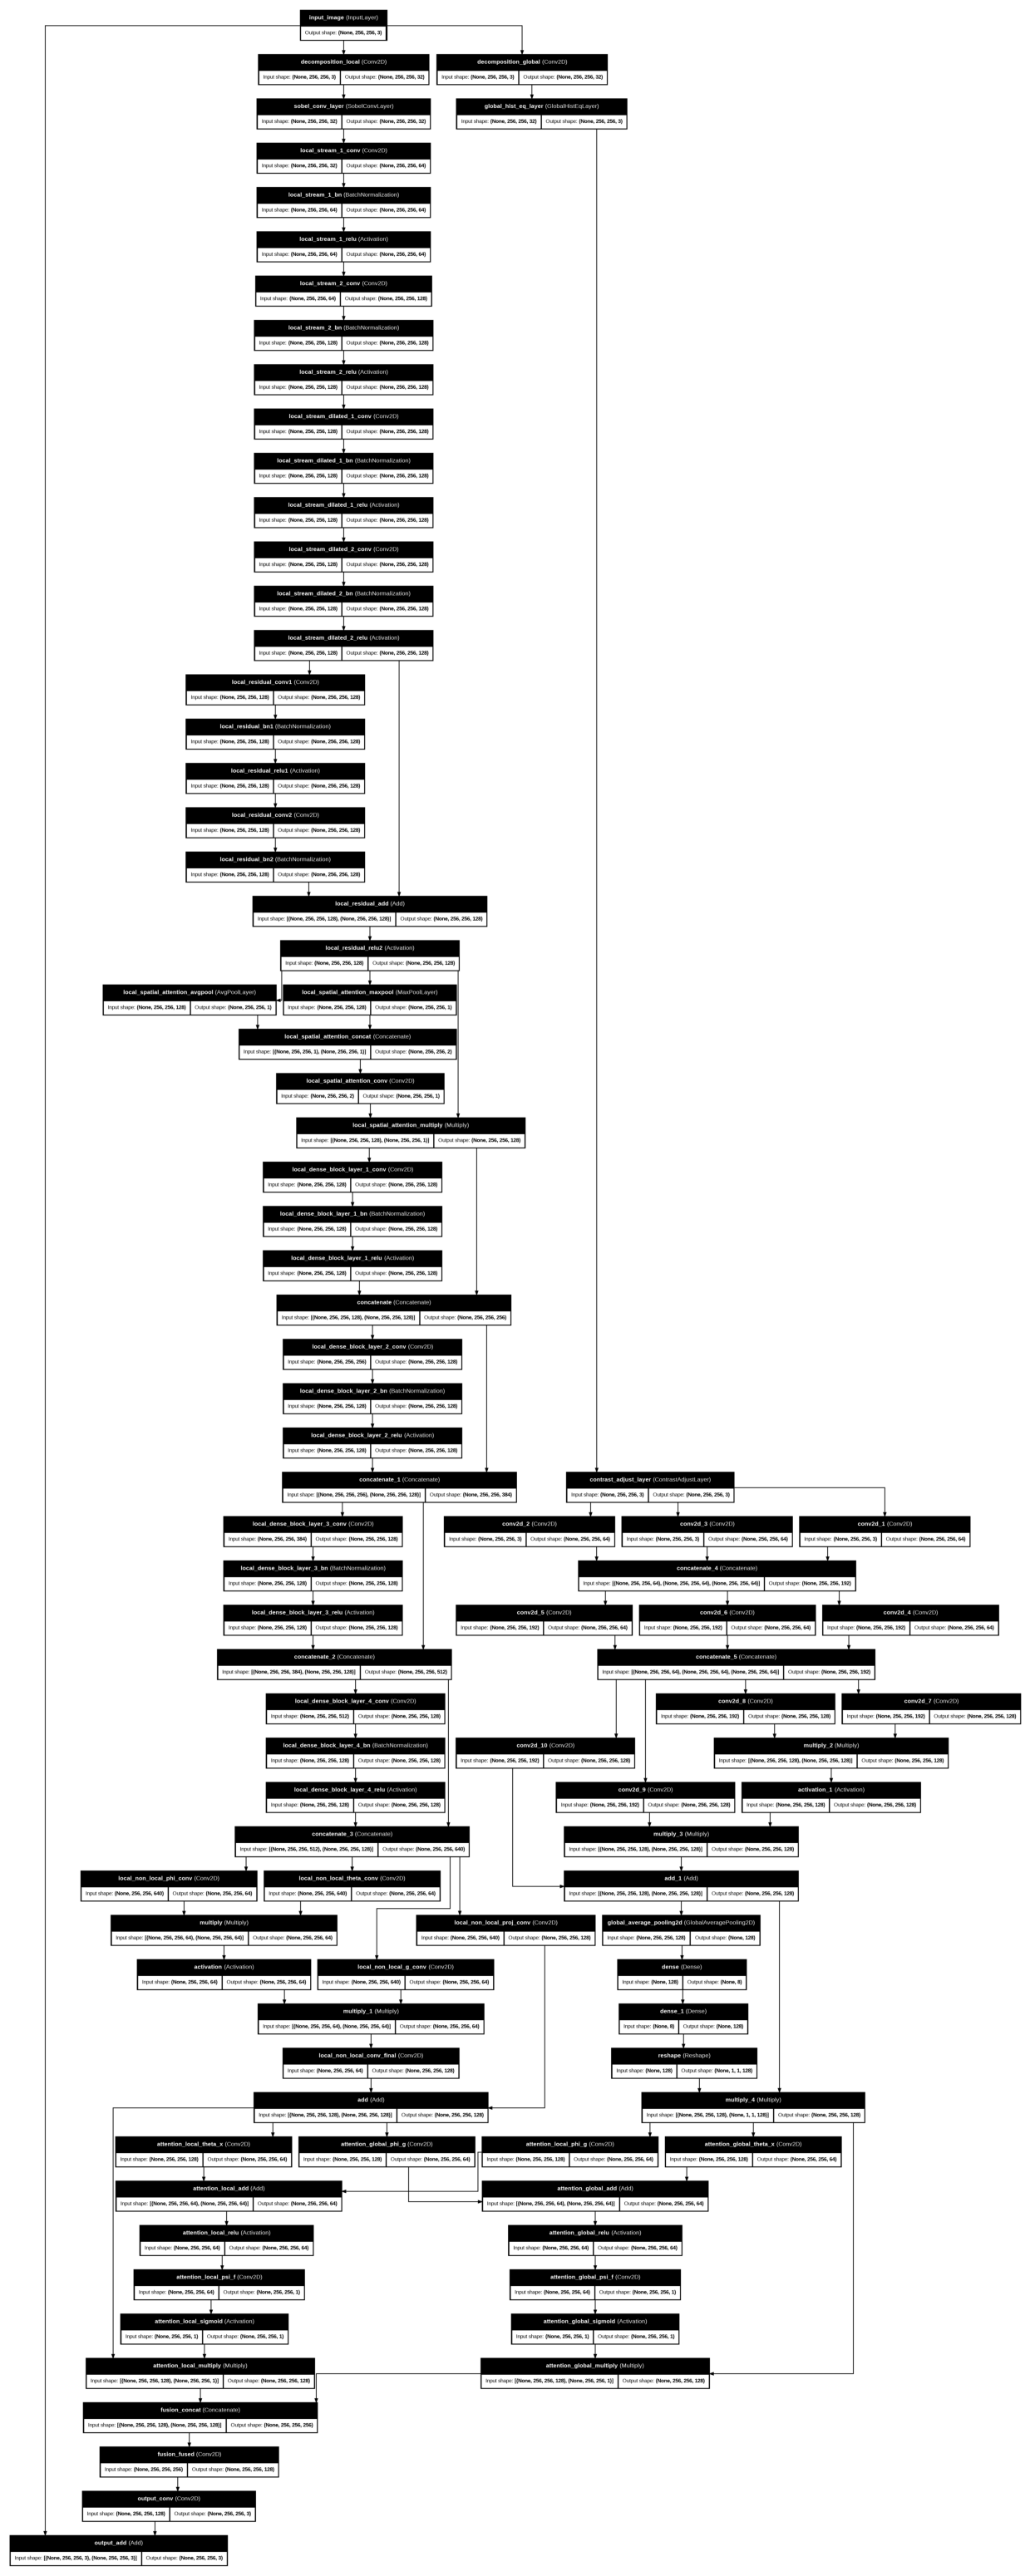

In [9]:
# Create a directory to save the plot if it doesn't exist
output_dir = 'model_plots'
os.makedirs(output_dir, exist_ok=True)

# Generate the initial plot
plot_model(
    lds_net_model,
    to_file=os.path.join(output_dir, 'lds_net_model.png'),
    show_shapes=True,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=True,
    dpi=96
)

# Load the generated graph (This is a static image, no need for pydot manipulation for color)
img_path = os.path.join(output_dir, 'lds_net_model.png')
img = mpimg.imread(img_path)
plt.figure(figsize=(40, 40))
plt.imshow(img)
plt.axis('off')
plt.show()

# 5. Load the Dataset for Model Training

In [ ]:
class ImageDataGenerator(Sequence):
    def __init__(self, data_paths, target_paths, batch_size=32, img_size=(256, 256), shuffle=True, percentage=100, is_training=True):
        self.data_paths = data_paths
        self.target_paths = target_paths
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.percentage = percentage
        self.is_training = is_training

        self.data_files = self.get_file_pairs()
        self.indexes = np.arange(len(self.data_files))

        if self.shuffle:
            np.random.shuffle(self.indexes)

    def get_file_pairs(self):
        all_pairs = []
        for data_path, target_path in zip(self.data_paths, self.target_paths):
            data_files = sorted(os.listdir(data_path))
            target_files = sorted(os.listdir(target_path))
            pairs = list(zip(
                [os.path.join(data_path, f) for f in data_files],
                [os.path.join(target_path, f) for f in target_files]
            ))
            # Select a percentage of the data from each path
            num_to_keep = int(len(pairs) * (self.percentage / 100))
            selected_pairs = random.sample(pairs, num_to_keep)
            all_pairs.extend(selected_pairs)

        return all_pairs

    def __len__(self):
        return int(np.ceil(len(self.data_files) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_indexes = self.indexes[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_pairs = [self.data_files[i] for i in batch_indexes]

        X_batch = np.array([self.load_image(pair[0]) for pair in batch_pairs])
        Y_batch = np.array([self.load_image(pair[1]) for pair in batch_pairs])

        return X_batch, Y_batch

    def load_image(self, file_path):
        img = load_img(file_path, target_size=self.img_size)
        img = img_to_array(img)
        img = (img / 127.5) - 1.0  # Normalize to [-1, 1]
        return img

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

# Verify GPU availability
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("Is GPU available: ", tf.test.is_gpu_available())

# Data paths
data_paths = [
    "/content/gdrive/My Drive/Colab Notebooks/LDS-Net/Data/MarineRobotImages/A",
    "/content/gdrive/My Drive/Colab Notebooks/LDS-Net/Data/underwater_scenes/A",
    "/content/gdrive/My Drive/Colab Notebooks/LDS-Net/Data/underwater_imagenet/A",
    "/content/gdrive/My Drive/Colab Notebooks/LDS-Net/Data/underwater_dark/A"
]

# Target paths
target_paths = [
    "/content/gdrive/My Drive/Colab Notebooks/LDS-Net/Data/MarineRobotImages/B",
    "/content/gdrive/My Drive/Colab Notebooks/LDS-Net/Data/underwater_scenes/B",
    "/content/gdrive/My Drive/Colab Notebooks/LDS-Net/Data/underwater_imagenet/B",
    "/content/gdrive/My Drive/Colab Notebooks/LDS-Net/Data/underwater_dark/B"
]

# Function to split data while maintaining equal distribution
def split_data(data_paths, target_paths, train_ratio=0.8):
    train_data_paths, train_target_paths = [], []
    val_data_paths, val_target_paths = [], []

    for data_path, target_path in zip(data_paths, target_paths):
        data_files = os.listdir(data_path)
        split_idx = int(len(data_files) * train_ratio)

        train_data_paths.append(data_path)
        train_target_paths.append(target_path)
        val_data_paths.append(data_path)
        val_target_paths.append(target_path)

    return train_data_paths, train_target_paths, val_data_paths, val_target_paths

# Split data
train_data_paths, train_target_paths, val_data_paths, val_target_paths = split_data(data_paths, target_paths)

# Create data generators
train_generator = ImageDataGenerator(train_data_paths, train_target_paths, batch_size=16, img_size=(256, 256), shuffle=True, percentage=40, is_training=True)
val_generator = ImageDataGenerator(val_data_paths, val_target_paths, batch_size=16, img_size=(256, 256), shuffle=False, percentage=8, is_training=False)

# Print statistics
print(f"Number of training samples: {len(train_generator.data_files)}")
print(f"Number of validation samples: {len(val_generator.data_files)}")

for i, (data_path, target_path) in enumerate(zip(data_paths, target_paths)):
    train_count = sum(1 for pair in train_generator.data_files if pair[0].startswith(data_path))
    val_count = sum(1 for pair in val_generator.data_files if pair[0].startswith(data_path))
    total_count = len(os.listdir(data_path))
    print(f"Dataset {i+1}:")
    print(f"  Total images: {total_count}")
    print(f"  Training images: {train_count} ({train_count/total_count:.2%})")
    print(f"  Validation images: {val_count} ({val_count/total_count:.2%})")

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


Num GPUs Available:  1
Is GPU available:  True
Number of training samples: 5507
Number of validation samples: 1099
Dataset 1:
  Total images: 4620
  Training images: 1848 (40.00%)
  Validation images: 369 (7.99%)
Dataset 2:
  Total images: 1748
  Training images: 699 (39.99%)
  Validation images: 139 (7.95%)
Dataset 3:
  Total images: 2960
  Training images: 1184 (40.00%)
  Validation images: 236 (7.97%)
Dataset 4:
  Total images: 4440
  Training images: 1776 (40.00%)
  Validation images: 355 (8.00%)


# 6. Train the Model

## 6.1. Perfom training

In [ ]:
# Set the number of epochs
epochs = 50

# Define callbacks for saving the best model and early stopping
checkpoint = ModelCheckpoint('lds_net_best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

# Record the start time
start_time = time.time()

# Train the model with learning rate schedule and early stopping
history = lds_net_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,  # You can set a reasonable number of epochs
    callbacks=[reduce_lr, checkpoint, early_stopping]
)

# Record the end time
end_time = time.time()

# Saving the final model
save_model(lds_net_model, 'lds_net_model.keras')

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


345/345 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - loss: 0.1256 - mean_absolute_error: 0.2743
Epoch 1: val_loss improved from inf to 0.08458, saving model to lds_net_best_model.keras
345/345 ━━━━━━━━━━━━━━━━━━━━ 3139s 8s/step - loss: 0.1255 - mean_absolute_error: 0.2742 - val_loss: 0.0846 - val_mean_absolute_error: 0.2195 - learning_rate: 1.0000e-05
Epoch 2/50
345/345 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - loss: 0.0745 - mean_absolute_error: 0.2070
Epoch 2: val_loss improved from 0.08458 to 0.07002, saving model to lds_net_best_model.keras
345/345 ━━━━━━━━━━━━━━━━━━━━ 175s 502ms/step - loss: 0.0745 - mean_absolute_error: 0.2070 - val_loss: 0.0700 - val_mean_absolute_error: 0.1995 - learning_rate: 1.0000e-05
Epoch 3/50
345/345 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - loss: 0.0709 - mean_absolute_error: 0.2006
Epoch 3: val_loss improved from 0.07002 to 0.06803, saving model to lds_net_best_model.keras
345/345 ━━━━━━━━━━━━━━━━━━━━ 175s 502ms/step - loss: 0.0709 - mean_absolute_error: 0.2006 - val_loss: 

## 6.2 Calculate the training duration

In [ ]:
training_duration = end_time - start_time

# Convert duration to hours, minutes, seconds
hours, rem = divmod(training_duration, 3600)
minutes, seconds = divmod(rem, 60)

# Print the start, end time, and duration
print(f"Training started at: {time.ctime(start_time)}")
print(f"Training ended at: {time.ctime(end_time)}")
print(f"Total training time: {int(hours)} hours, {int(minutes)} minutes, and {int(seconds)} seconds")

## 6.3. Plot training Matrices

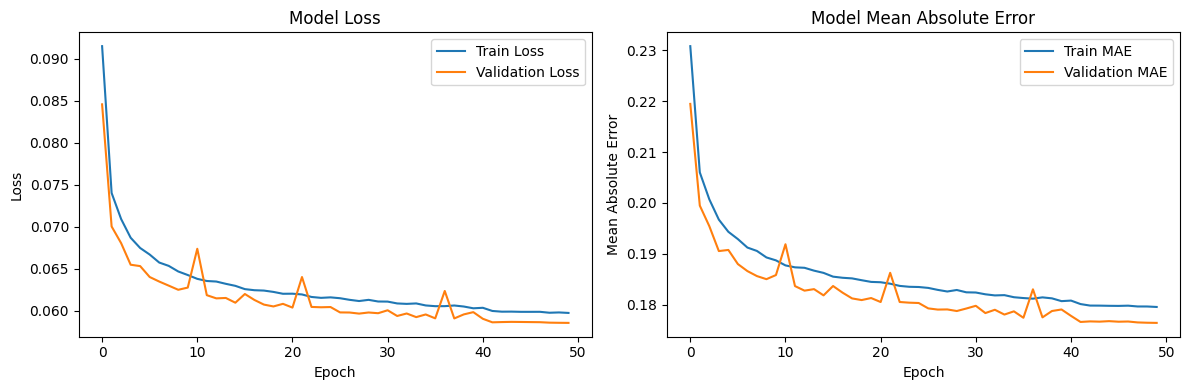

In [ ]:
plt.figure(figsize=(12, 4))

# Plot the Loss
plt.subplot(121)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot the Mean Absolute Error (MAE)
plt.subplot(122)
plt.plot(history.history['mean_absolute_error'], label='Train MAE')
plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
plt.title('Model Mean Absolute Error')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()

plt.tight_layout()
plt.show()


## 6.4. Print the loss and metric values for each epoch

In [ ]:
print("Available keys in history:", history.history.keys())

Available keys in history: dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error', 'learning_rate'])


In [ ]:
# Get the number of epochs
num_epochs = len(history.history['loss'])

print("Epoch\t Loss\t MAE\t Val Loss\t Val MAE")
print("-------------------------------------------------")

for epoch in range(num_epochs):
    loss = history.history['loss'][epoch]
    mae = history.history['mean_absolute_error'][epoch]
    val_loss = history.history['val_loss'][epoch]
    val_mae = history.history['val_mean_absolute_error'][epoch]

    print(f"{epoch+1}\t {loss:.4f}\t {mae:.4f}\t {val_loss:.4f}\t {val_mae:.4f}")

Epoch	 Loss	 MAE	 Val Loss	 Val MAE
-------------------------------------------------
1	 0.0915	 0.2308	 0.0846	 0.2195
2	 0.0740	 0.2060	 0.0700	 0.1995
3	 0.0709	 0.2007	 0.0680	 0.1955
4	 0.0687	 0.1967	 0.0655	 0.1906
5	 0.0675	 0.1943	 0.0653	 0.1908
6	 0.0667	 0.1929	 0.0640	 0.1880
7	 0.0657	 0.1913	 0.0635	 0.1866
8	 0.0653	 0.1906	 0.0630	 0.1857
9	 0.0647	 0.1893	 0.0625	 0.1850
10	 0.0642	 0.1887	 0.0627	 0.1859
11	 0.0638	 0.1877	 0.0674	 0.1919
12	 0.0635	 0.1874	 0.0618	 0.1837
13	 0.0635	 0.1873	 0.0615	 0.1828
14	 0.0632	 0.1867	 0.0615	 0.1831
15	 0.0629	 0.1863	 0.0609	 0.1819
16	 0.0626	 0.1855	 0.0620	 0.1837
17	 0.0624	 0.1853	 0.0613	 0.1824
18	 0.0624	 0.1852	 0.0607	 0.1813
19	 0.0622	 0.1848	 0.0605	 0.1809
20	 0.0620	 0.1845	 0.0608	 0.1813
21	 0.0620	 0.1844	 0.0604	 0.1806
22	 0.0619	 0.1842	 0.0640	 0.1863
23	 0.0616	 0.1837	 0.0604	 0.1806
24	 0.0615	 0.1836	 0.0604	 0.1804
25	 0.0616	 0.1835	 0.0604	 0.1804
26	 0.0615	 0.1833	 0.0598	 0.1793
27	 0.0613	 0

# 7. Evaluating the model perfrmance

## 7.1. Loading the model

In [13]:
# Loading the model
lds_net_model = load_model('lds_net_model.keras')

## 7.2. Load the Paired test Data

In [ ]:
def load_paired_images(folder_A, folder_B, percentage=20, target_size=(256, 256)):
    # Get all image file names from Folder A (assuming the same names exist in Folder B)
    images_A = [f for f in os.listdir(folder_A) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    images_B = [f for f in os.listdir(folder_B) if f in images_A]  # Ensure matching pairs exist

    if not images_A or not images_B:
        raise ValueError(f"No valid image pairs found in {folder_A} and {folder_B}")

    # Randomly shuffle the paired images
    paired_images = list(zip(images_A, images_B))
    np.random.shuffle(paired_images)

    # Select a subset of images based on the percentage
    num_images = max(1, int(len(paired_images) * (percentage / 100)))
    selected_pairs = paired_images[:num_images]

    inputs, targets = [], []

    # Load and preprocess each paired image
    for img_A, img_B in selected_pairs:
        # Load and preprocess input image (Folder A)
        img_A_path = os.path.join(folder_A, img_A)
        input_img = img_to_array(load_img(img_A_path, target_size=target_size)) / 255.0

        # Load and preprocess target image (Folder B)
        img_B_path = os.path.join(folder_B, img_B)
        target_img = img_to_array(load_img(img_B_path, target_size=target_size)) / 255.0

        inputs.append(input_img)
        targets.append(target_img)

    return np.array(inputs), np.array(targets)

# Load images from the paired folders for each test set
X_test_1, Y_test_1 = load_paired_images(
    "/content/gdrive/My Drive/Colab Notebooks/LDS-Net/Data/underwater_scenes/test/A",
    "/content/gdrive/My Drive/Colab Notebooks/LDS-Net/Data/underwater_scenes/test/B",
    percentage=20
)

X_test_2, Y_test_2 = load_paired_images(
    "/content/gdrive/My Drive/Colab Notebooks/LDS-Net/Data/underwater_imagenet/test/A",
    "/content/gdrive/My Drive/Colab Notebooks/LDS-Net/Data/underwater_imagenet/test/B",
    percentage=20
)

X_test_3, Y_test_3 = load_paired_images(
    "/content/gdrive/My Drive/Colab Notebooks/LDS-Net/Data/underwater_dark/test/A",
    "/content/gdrive/My Drive/Colab Notebooks/LDS-Net/Data/underwater_dark/test/B",
    percentage=20
)

X_test_4, Y_test_4 = load_paired_images(
    "/content/gdrive/My Drive/Colab Notebooks/LDS-Net/Data/MarineRobotImages/test/A",
    "/content/gdrive/My Drive/Colab Notebooks/LDS-Net/Data/MarineRobotImages/test/B",
    percentage=20
)

# Combine all test data
X_test = np.concatenate([X_test_1, X_test_2, X_test_3, X_test_4])
Y_test = np.concatenate([Y_test_1, Y_test_2, Y_test_3, Y_test_4])

print(f"Loaded {X_test.shape[0]} input-target pairs.")

# Ensure the input and target shapes match
assert X_test.shape == Y_test.shape, "Input and target shapes do not match!"

Loaded 458 input-target pairs.


## 7.3. Perform inference and evaluate the model

In [ ]:
# Perform inference and evaluate the model
print("Evaluating the LDS-Net model...")
predictions = lds_net_model.predict(X_test)

#Flatten the arrays for per-image metric calculation
X_test_flat = X_test.reshape((X_test.shape[0], -1))  # (num_samples, height * width * channels)
predictions_flat = predictions.reshape((predictions.shape[0], -1))  # Same shape as X_test_flat

# Calculate MSE and MAE for each image in the test set
mse_per_image = np.mean((X_test_flat - predictions_flat) ** 2, axis=1)  # MSE per image
mae_per_image = np.mean(np.abs(X_test_flat - predictions_flat), axis=1)  # MAE per image

# Print summary statistics for the errors
print(f"Average MSE: {np.mean(mse_per_image):.6f}")
print(f"Average MAE: {np.mean(mae_per_image):.6f}")

Evaluating the LDS-Net model...
15/15 ━━━━━━━━━━━━━━━━━━━━ 37s 915ms/step
Average MSE: 0.019011
Average MAE: 0.065712


## 7.4. Plot predictions vs. ground truth

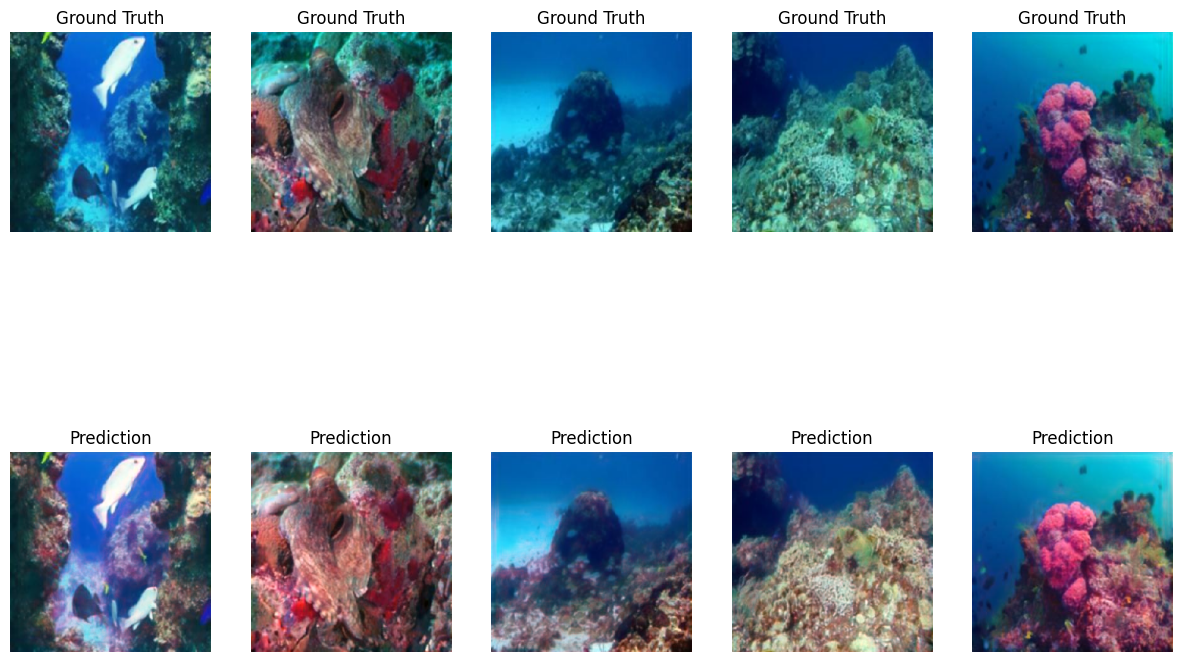

In [ ]:
# Plot predictions vs. ground truth
def plot_comparison(X_test, predictions, num_images=5):
    plt.figure(figsize=(15, 10))
    for i in range(num_images):
        # Ground Truth
        plt.subplot(2, num_images, i + 1)
        plt.imshow(X_test[i])
        plt.title("Ground Truth")
        plt.axis('off')

        # Prediction
        plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(predictions[i])
        plt.title("Prediction")
        plt.axis('off')

    plt.show()

# Plot the comparison of the first 5 predictions with their ground truth
plot_comparison(X_test, predictions, num_images=5)

## 7.5. Plot MSE and MAE distribution

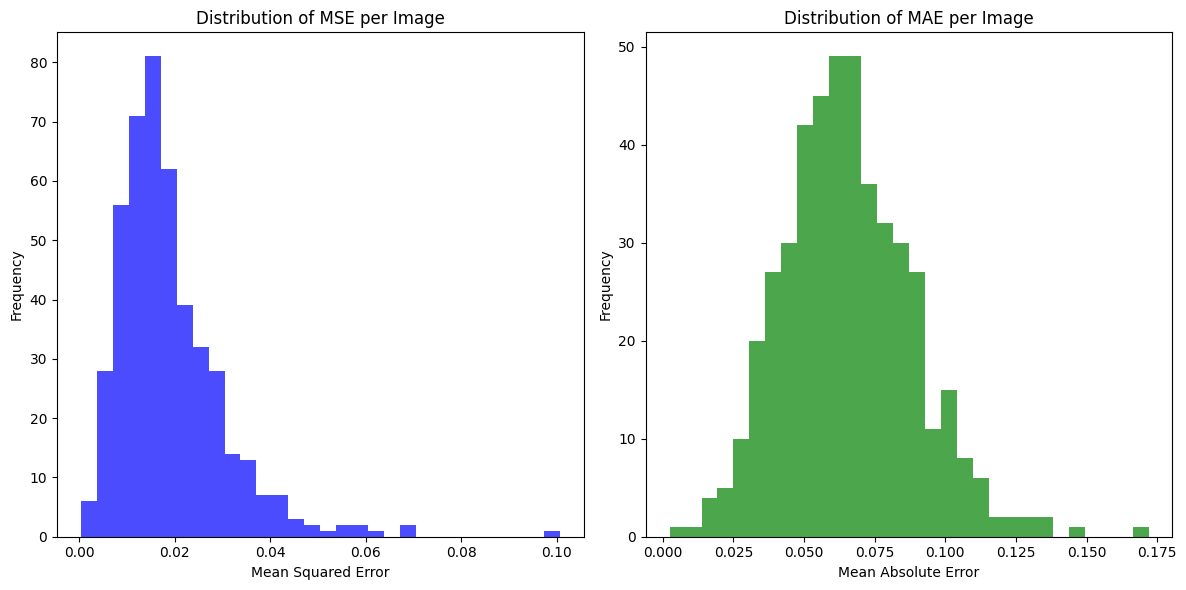

In [ ]:
plt.figure(figsize=(12, 6))

# Plot MSE distribution
plt.subplot(1, 2, 1)
plt.hist(mse_per_image, bins=30, color='blue', alpha=0.7)
plt.title('Distribution of MSE per Image')
plt.xlabel('Mean Squared Error')
plt.ylabel('Frequency')

# Plot MAE distribution
plt.subplot(1, 2, 2)
plt.hist(mae_per_image, bins=30, color='green', alpha=0.7)
plt.title('Distribution of MAE per Image')
plt.xlabel('Mean Absolute Error')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


## 7.6. Visual Comarison of Sample Enhanced Images

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


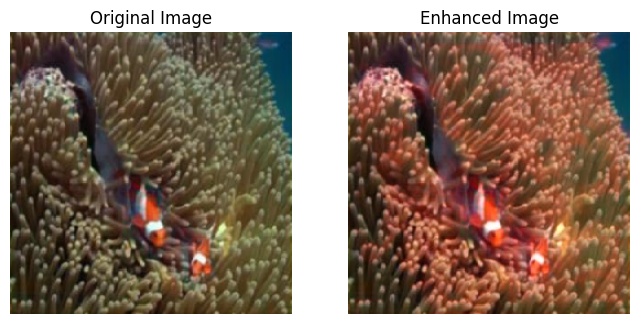

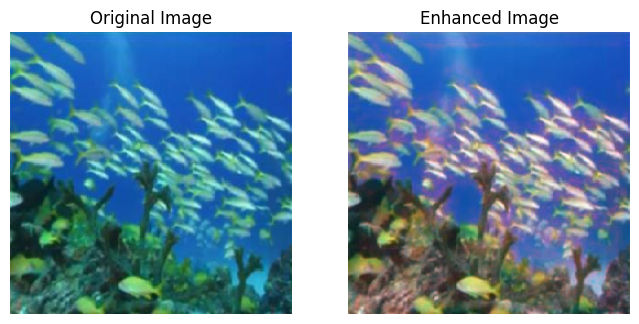

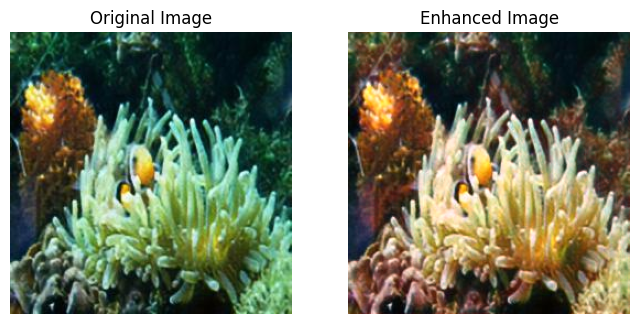

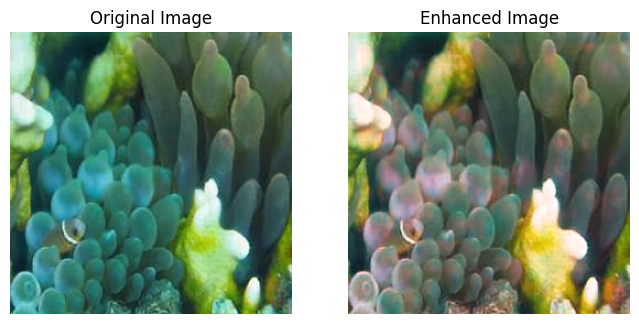

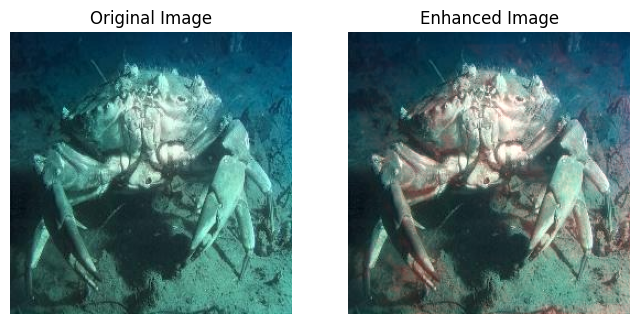

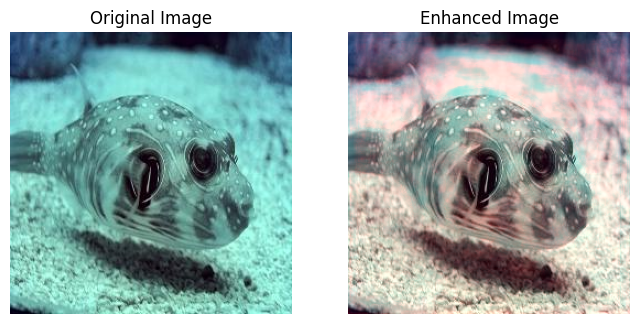

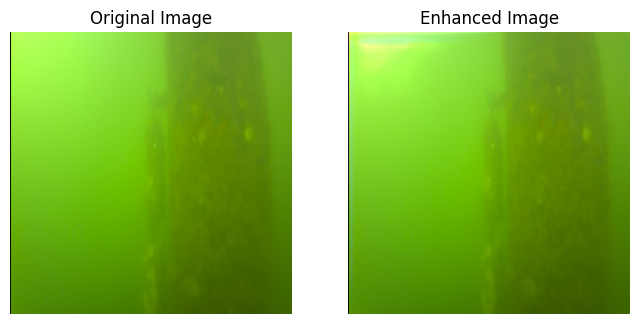

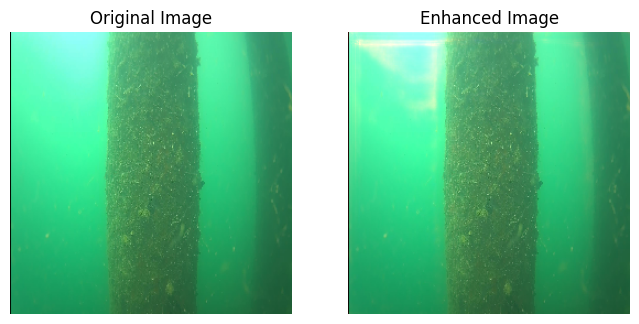

In [15]:
import tensorflow as tf
import os
import random
import numpy as np
import matplotlib.pyplot as plt

# Load the trained LDS-Net model
lds_net_model = tf.keras.models.load_model('lds_net_model.keras')

def load_images_from_folder(folder_path, target_size=(256, 256), num_samples=1):
    """Load and preprocess a limited number of images from a folder."""
    images = []
    filenames = random.sample(os.listdir(folder_path), min(num_samples, len(os.listdir(folder_path))))  # Select random files

    for filename in filenames:
        img_path = os.path.join(folder_path, filename)
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=target_size)
        img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0  # Normalize to [0, 1]
        images.append(img_array)

    return np.array(images)

# Load random images from each test folder
test_data_1 = load_images_from_folder("/content/gdrive/My Drive/Colab Notebooks/LDS-Net/Data/underwater_scenes/test/A", num_samples=2)
test_data_2 = load_images_from_folder("/content/gdrive/My Drive/Colab Notebooks/LDS-Net/Data/underwater_imagenet/test/A", num_samples=2)
test_data_3 = load_images_from_folder("/content/gdrive/My Drive/Colab Notebooks/LDS-Net/Data/underwater_dark/test/A",num_samples=2)
test_data_4 = load_images_from_folder("/content/gdrive/My Drive/Colab Notebooks/LDS-Net/Data/MarineRobotImages/test/A",num_samples=2)

# Combine all test data
test_data = np.concatenate([test_data_1, test_data_2, test_data_3, test_data_4], axis=0)

# Generate predictions for the loaded test images
predictions = lds_net_model.predict(test_data)

def plot_comparison(original, enhanced, index):
    """Plot comparison between original and enhanced images."""
    plt.figure(figsize=(8, 4))

    # Original Image
    plt.subplot(1, 2, 1)
    plt.imshow(original)
    plt.title('Original Image')
    plt.axis('off')

    # Enhanced Image
    plt.subplot(1, 2, 2)
    plt.imshow(enhanced)
    plt.title('Enhanced Image')
    plt.axis('off')

    plt.show()

# Display comparison for all available samples
num_samples = min(len(test_data), len(predictions))  # Ensure loop limit is valid
for i in range(num_samples):
    plot_comparison(test_data[i], predictions[i], i)
